# 71 Dropout regularization

In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

## Using dropout

In [16]:
# Define a dropout instance and make some data
prob = 0.25

dropout = nn.Dropout(p=prob) # drop out is a class
x = torch.ones(10)
y = dropout(x) # it seems the instance 

In [17]:
y # set 25% of x to zeros, while scale up the remaining by 1/(1-prob)

tensor([1.3333, 1.3333, 1.3333, 1.3333, 1.3333, 0.0000, 0.0000, 1.3333, 0.0000,
        1.3333])

In [18]:
y.sum() # smaller than sum of x because it set 3 values to zero instead of 2.5

tensor(9.3333)

In [20]:
# dropout is turned off when evaluating the model
dropout.eval()
y = dropout(x)
print(y)
print(y.mean())

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(1.)


In [32]:
# Using F.dropout(), which is not deactivated in the eval mode:
dropout.eval()
y = F.dropout(x)
print(y)
print(torch.mean(y))

# but you can manually switch it off
y = F.dropout(x, training=False)
print('\nAfter manually switch off dropout')
print(y)
print(torch.mean(y))

tensor([0., 2., 2., 0., 2., 2., 0., 2., 2., 2.])
tensor(1.4000)

After manually switch off dropout
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(1.)


In [39]:
# the model needs to be reset after toggling into eval mode

dropout.train()
y = dropout(x)
print('With dropout')
print(y)

dropout.eval()
y = dropout(x)
print('\nWithout dropout')
print(y)

#dropout.train()
y = dropout(x)
print('\nStill Without dropout')
print(y)

# each time you switch to eval mode, you need to switch back to train mode for further learning
dropout.train()
y = dropout(x)
print('\nSwitch on dropout')
print(y)

With dropout
tensor([1.3333, 0.0000, 1.3333, 1.3333, 1.3333, 1.3333, 0.0000, 1.3333, 1.3333,
        1.3333])

Without dropout
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Still Without dropout
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Switch on dropout
tensor([1.3333, 1.3333, 1.3333, 1.3333, 1.3333, 1.3333, 1.3333, 1.3333, 1.3333,
        1.3333])


# 72 Dropout regularization in practice

In [44]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

## Create the data

In [110]:
# create data
nPerClust = 200

th = np.linspace(0, 4*np.pi, nPerClust)
r1 = 10
r2 = 15

# generate data
a = [r1 * np.cos(th) + np.random.randn(nPerClust) *3, 
     r1 * np.sin(th) + np.random.randn(nPerClust)]

b = [r2 * np.cos(th) + np.random.randn(nPerClust), 
     r2 * np.sin(th) + np.random.randn(nPerClust) * 3]

In [112]:
# true labels
labels_np = np.vstack((np.zeros((nPerClust, 1)), np.ones((nPerClust, 1))))

In [121]:
# concatenate into a matrix
data_np = np.hstack((a, b)).T

In [122]:
# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

Text(0, 0.5, 'qwerty dimension 2')

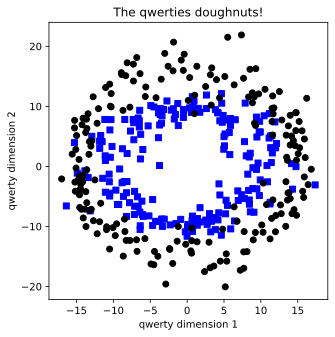

In [126]:
# show the data
zero_bool = (labels == 0)[:, 0] # labels == 0 is a 400 X 1 tensor, need to index
one_bool = (labels == 1)[:, 0]
fig = plt.figure(figsize=(5, 5))
plt.plot(data[zero_bool, 0], data[zero_bool, 1], 'bs')
plt.plot(data[one_bool, 0], data[one_bool, 1], 'ko')

plt.title('The qwerties doughnuts!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')

## Separate the data into DatLoaders

In [140]:
# use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size= 0.2
)

# Then convert them into PyTorch Datasets (They are already tensors)
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Translate into dataloader objects
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# test_data.tensors returns a 2-element tuple, the first one is X, and the second one is y
# below batch_size, we can use test_data.tensors[0].shape[0]
print(test_data.tensors[0].shape[0])
test_loader = DataLoader(test_data, batch_size=len(test_data)) # it is actually one batch

80


## create the model

In [143]:
# define model class
class theModelClass(nn.Module):
    def __init__(self, dropoutRate):
        super().__init__()

        ### layers
        self.input =nn.Linear(2, 128)
        self.hidden = nn.Linear(128, 128)
        self.output = nn.Linear(128, 1)

        # parameters
        self.dr = dropoutRate

    def forward(self, x):

        # pass the data through the input layer
        x = F.relu(self.input(x))

        # dropout after input layer
        # when model is in training, self.training is set to True
        # when model is in eval model, it is set to False
        x = F.dropout(x, p=self.dr, training=self.training)

        # pass the data through the hidden layer
        x = F.relu(self.hidden(x))

        # dropout after hidden layer
        x = F.dropout(x, p = self.dr, training=self.training)

        # output layer
        x = self.output(x)
        # no dropout here!

        return x

In [146]:
# test the model
tmpnet = theModelClass(0.25)

# run some random data through
tmpdata = torch.randn((10, 2))
yhat = tmpnet(tmpdata)
yhat

tensor([[-0.1744],
        [ 0.0689],
        [-0.0950],
        [-0.0880],
        [ 0.0195],
        [-0.0597],
        [-0.2878],
        [-0.0292],
        [-0.1546],
        [-0.0661]], grad_fn=<AddmmBackward0>)

## Functions to create and train the net

In [148]:
# define a function to create models
def create_model(drop_out_rate):

    # instantiate the model class
    ANNQC = theModelClass(drop_out_rate)

    # loss function
    lossfunc = nn.BCEWithLogitsLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANNQC.parameters(), lr = 0.002)

    return ANNQC, lossfunc, optimizer

In [152]:
# define a function to train models
numepochs = 1000

# define a helper func
def calc_accuracy(yHat, y):
    fc_label = yHat > 0.5
    fc = (fc_label == y).float()
    return 100 * torch.mean(fc).item()

def train_model(ANNQC, lossfunc, optimizer, train_loader, test_loader):

    # Initiate accuracy lists
    trainAcc = []
    testAcc = []

    

    for epochi in range(numepochs):
        # loop over training data batches

        # swithcing train mode on (is this the right place for this code?)
        ANNQC.train()

        batchAcc = []
        for X, y in train_loader:

            # forward pass the loss
            yHat = ANNQC(X)
            loss = lossfunc(yHat, y)

            # back prop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute the training accuracy just for this batch
            batchAcc.append(calc_accuracy(yHat, y))

        # end of batch loop
            
        # get the average training accuracy of a batches for one epoch
        trainAcc.append(np.mean(batchAcc))

        # test accuray
        ANNQC.eval() # switch training off
        X, y = next(iter(test_loader))

        yHat = ANNQC(X)
        testAcc.append(calc_accuracy(yHat, y))

    # function output
    return trainAcc, testAcc


## Test a model

In [166]:
# create a model
drop_out_rate = 0
ANNQC, lossfunc, optimizer = create_model(drop_out_rate)

# train the model
trainAcc, testAcc = train_model(ANNQC, lossfunc, optimizer, train_loader, test_loader)

In [ ]:
# create a 1D smoothing filter
def smooth(x, k = 5):
    return np.convolve(x, np.ones(k) / k, mode = 'same')

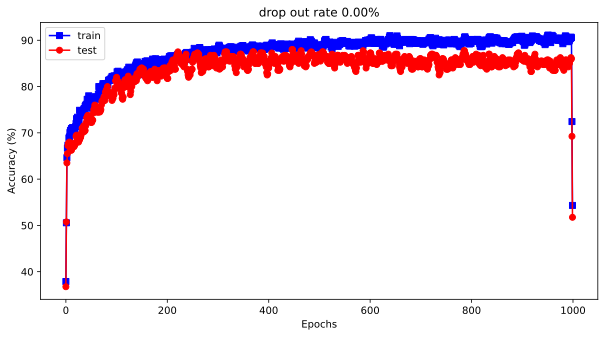

In [167]:
# plot the results
fig = plt.figure(figsize=(10, 5))
plt.plot(range(numepochs), smooth(trainAcc), 'bs-')
plt.plot(smooth(testAcc), 'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title(f'drop out rate {drop_out_rate*100:.2f}%')
plt.legend(['train', 'test'])
plt.show()

In [177]:
# run an experiment to vary drop out rate
dropRates = np.arange(10)/10

results = np.zeros((len(dropRates), 2))

for di in range(len(dropRates)):
    ANNQC, lossfunc, optimizer = create_model(drop_out_rate = dropRates[di])
    trainAcc, testAcc = train_model(ANNQC, lossfunc, optimizer, train_loader, test_loader)

    # store accuracies fro mthe last 100 epochs
    results[di, 0] = np.mean(trainAcc[-100:])
    results[di, 1] = np.mean(testAcc[-100:])

    

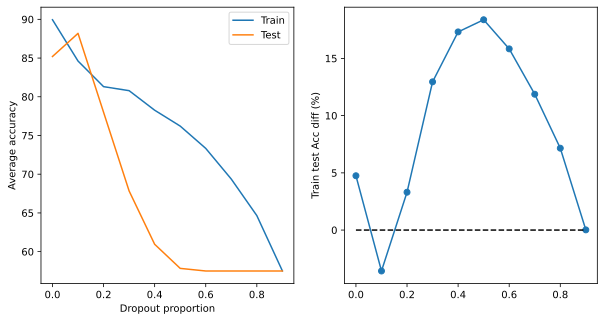

In [185]:
# plot the experiment results
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].plot(dropRates, results)
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train', 'Test'])

ax[1].plot(dropRates, -np.diff(results, axis=1), 'o-')
ax[1].plot([0, 0.9], [0, 0], 'k--') # draw a horizontal line at 0
ax[0].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train test Acc diff (%)')
#ax[1].legend(['Train', 'Test'])
plt.show()





In [172]:
x

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [176]:
x[-2]

8

# 73 Dropout example 2

In [221]:
# import library
import torch
import torch.nn as nn
from torch.nn import Dropout
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

## loand iris data

In [230]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa'] = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

## Split and Translate data

In [237]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)


# finally, translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0]) # how big should these batches be??


In [258]:
for X, y in train_loader:
    print(X)
    print(y)

tensor([[7.7000, 2.8000, 6.7000, 2.0000],
        [7.9000, 3.8000, 6.4000, 2.0000],
        [6.9000, 3.2000, 5.7000, 2.3000],
        [6.0000, 2.2000, 5.0000, 1.5000],
        [5.8000, 2.7000, 5.1000, 1.9000],
        [6.6000, 3.0000, 4.4000, 1.4000],
        [5.6000, 3.0000, 4.1000, 1.3000],
        [5.0000, 3.0000, 1.6000, 0.2000],
        [5.0000, 3.5000, 1.3000, 0.3000],
        [5.6000, 2.7000, 4.2000, 1.3000],
        [6.7000, 3.3000, 5.7000, 2.1000],
        [4.3000, 3.0000, 1.1000, 0.1000],
        [5.7000, 3.0000, 4.2000, 1.2000],
        [6.4000, 3.2000, 4.5000, 1.5000],
        [7.2000, 3.0000, 5.8000, 1.6000],
        [4.8000, 3.0000, 1.4000, 0.1000]])
tensor([2, 2, 2, 2, 2, 1, 1, 0, 0, 1, 2, 0, 1, 1, 2, 0])
tensor([[4.5000, 2.3000, 1.3000, 0.3000],
        [7.7000, 3.0000, 6.1000, 2.3000],
        [6.1000, 3.0000, 4.6000, 1.4000],
        [5.7000, 2.8000, 4.1000, 1.3000],
        [6.4000, 2.7000, 5.3000, 1.9000],
        [6.1000, 2.8000, 4.0000, 1.3000],
        [6.2000, 3

## create the model class

In [254]:
# create a customize model using class
class CreateIrisModel(nn.Module):

    def __init__(self, drop_out_rate):
        super().__init__()

     ### layers
        self.input  = nn.Linear(4,12)
        self.hidden = nn.Linear(12,12)
        self.output = nn.Linear(12, 3)

        # parameters
        self.dr = drop_out_rate

  # forward pass
    def forward(self,x):

        # input
        x = F.relu( self.input(x) )
        x = F.dropout(x,p=self.dr,training=self.training) # switch dropout off during .eval()
        
        # hidden
        x = F.relu( self.hidden(x) )
        x = F.dropout(x,p=self.dr,training=self.training)
        
        # output
        x = self.output(x)
        return x

        



In [255]:
# test the model
ANNIris = CreateIrisModel(0.25)
# run some random data through
tmpdata = torch.randn((10,4))
yHat = ANNIris(tmpdata)
print(yHat)

tensor([[ 0.0949,  0.1302, -0.2977],
        [ 0.1944,  0.3277, -0.1217],
        [ 0.2790,  0.1378, -0.3872],
        [ 0.2394,  0.0563, -0.1094],
        [ 0.3024,  0.2940,  0.1604],
        [ 0.2496,  0.1228, -0.1919],
        [ 0.3407,  0.2672,  0.1048],
        [ 0.0682,  0.4226, -0.2641],
        [ 0.1218,  0.3225, -0.3587],
        [ 0.4783,  0.2521, -0.2594]], grad_fn=<AddmmBackward0>)


## functions to create models

In [248]:
# model function
drop_out_rate = 0.1
def create_ann_iris(drop_out_rate):
    ANNIris = CreateIrisModel(drop_out_rate=drop_out_rate)

    lossfunc = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(ANNIris.parameters(), lr=0.002)

    return ANNIris, lossfunc, optimizer
    

In [270]:
# function to train models
numepochs = 1000

# define a helper function
def calc_accuracy(yHat, y):
    fc_label = torch.argmax(yHat, axis = 1)
    fc_match = (fc_label == y).float()

    # torch.mean return a tensor, item() return a scale float
    return 100 * torch.mean(fc_match).item()
    

def train_iris_model(ANNIris, lossfunc, optimizer, train_loader, test_loader, drop_out_rate):

    trainAcc = []
    testAcc = []
    
    for epochi in range(numepochs):

        # set train mode
        ANNIris.train()

        batchAcc = []
        for X, y in train_loader: 
            
            # forward pass
            yHat = ANNIris(X)

            # loss
            loss = lossfunc(yHat, y)

            # back propogation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # calculate batch accuracy
            batchAcc.append(calc_accuracy(yHat, y))

        # end of batch train
            
        # train accuracy
        trainAcc.append(np.mean(batchAcc))

        # test accuracy
        ANNIris.eval()
        X, y = next(iter(test_loader))
        yHat = ANNIris(X)
        testAcc.append(calc_accuracy(yHat, y))

    return trainAcc, testAcc


In [275]:
# test model by one run
drop_out_rate = 0
ANNIris, lossfunc, optimizer = create_ann_iris(drop_out_rate=drop_out_rate)

trainAcc, testAcc = train_iris_model(ANNIris, lossfunc, optimizer, train_loader, test_loader, drop_out_rate)

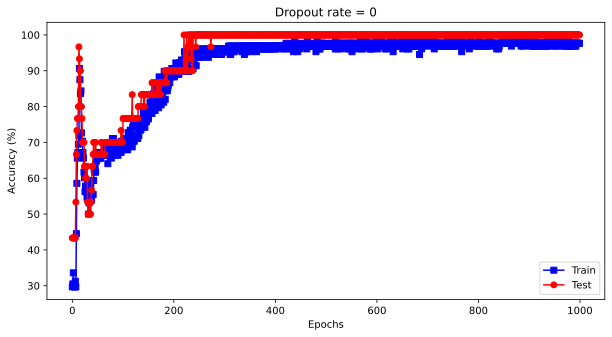

In [276]:
# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(trainAcc,'bs-')
plt.plot(testAcc,'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.title('Dropout rate = %g'%drop_out_rate)

plt.show()

In [280]:
# do an experiment
dropRates = np.arange(10) / 10
results = np.zeros((len(dropRates), 2))
for i in range(len(dropRates)):
    drop_out_rate = dropRates[i]

    ANNIris, lossfunc, optimizer = create_ann_iris(drop_out_rate=drop_out_rate)

    trainAcc, testAcc = train_iris_model(ANNIris, lossfunc, optimizer, train_loader, test_loader, drop_out_rate)

    results[i, 0] = np.mean(trainAcc[-50:])
    results[i, 1] = np.mean(testAcc[-50:])


    

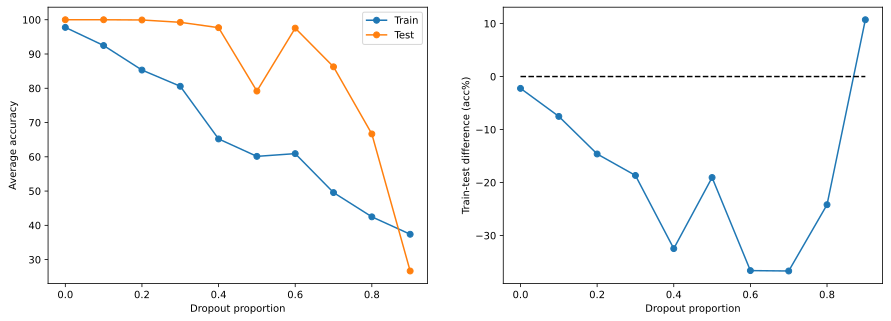

In [281]:
# plot
# plot the experiment results
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(dropRates,results,'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train','Test'])

ax[1].plot(dropRates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()

# 75 L2 regularization in practice

In [371]:
import torch
import torch.nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

Import data

In [372]:
# import iris dataset from seaborn
import seaborn as sns
iris = sns.load_dataset('iris')


In [373]:
# from pandas dataframe to tensor
data = torch.tensor(iris[iris.columns[0:4]].values).float()
labels = torch.zeros(len(iris)).long()
labels[iris.species == 'versicolor'] = 1
labels[iris.species == 'virginica'] = 2


In [374]:
labels.dtype

torch.int64

In [375]:
# break data into batches
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size= 0.2)

# convert data into pytorch dataset
train_dataDataset = TensorDataset(train_data, train_labels)
test_dataDataset = TensorDataset(test_data, test_labels)

# create dataloader
batch_size = 64
train_loader = DataLoader(train_dataDataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataDataset, batch_size=len(test_data))

The model

In [376]:
labels.dtype

torch.int64

In [388]:
# the model
# torch has already build in the L2 regulariztion in it

# define a function to creates the ANN model
def CreateANewModel(L2lambda):

    # model architeture
    ANNIris = nn.Sequential(
        nn.Linear(4, 64), # input layer
        nn.ReLU(), # activation unit
        nn.Linear(64, 64), # hidden layer
        nn.ReLU(), # Activation unit
        nn.Linear(64, 3), # output layer
    )

    lossfunc = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(ANNIris.parameters(), lr=0.005, weight_decay=L2lambda)

    return ANNIris, lossfunc, optimizer
    

In [389]:
# train function
# global parameter
numepochs = 1000

# helper function
def calc_accuracy(yHat, y):
    matched_label = torch.argmax(yHat, axis = 1)
    fc = (matched_label == y).float()
    return 100 * torch.mean(fc).item()

def train_model(ANNIris, lossfunc, optimizer, train_loader, test_loader):

    trainAcc = []
    testAcc = []
    losses = []

    for epochi in range(numepochs):

        # batchAccuracy
        batchAcc = []
        batchLoss = []
        
        for X, y in train_loader:

            # forward pass
            yHat = ANNIris(X)

            # loss
            loss = lossfunc(yHat, y)

            # back propogation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchAcc.append(calc_accuracy(yHat, y))
            batchLoss.append(loss.item())

        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))

        # test accuracy
        # model eval model do two folds: 
        # 1. turn of dropout regularization
        # 2. turn off batch normalization
        # We don't do either dropout or batch normalization here.
        # therefore we don't need it
        # ANNIris.eval() # set the model to eval mode. 
        X, y = next(iter(test_loader))
        yHat = ANNIris(X)
        testAcc.append(calc_accuracy(yHat, y))

        # toggle the model to train mode
        # ANNIris.train()
    # print(loss.item())

    return trainAcc, testAcc, losses
    

In [390]:
# create and run the model once
L2lambda = 0.01
ANNIris, lossfunc, optimizer = CreateANewModel(L2lambda)
trainAcc, testAcc, losses = train_model(ANNIris, lossfunc, optimizer, train_loader, test_loader)

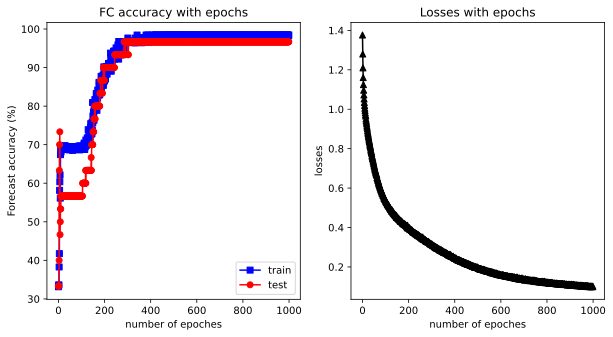

In [391]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].plot(trainAcc, 'bs-')
ax[0].plot(testAcc, 'ro-')
ax[0].set_xlabel('number of epoches')
ax[0].set_ylabel('Forecast accuracy (%)')
ax[0].set_title('FC accuracy with epochs')
ax[0].legend(['train', 'test'])

ax[1].plot(losses, 'k^-')
ax[1].set_xlabel('number of epoches')
ax[1].set_ylabel('losses')
ax[1].set_title('Losses with epochs')

plt.show()

In [420]:
# run an experiment
L2_space = np.linspace(0, 0.1, 10)
results = np.zeros((len(L2_space), 2))

loss_L2 = []


for i, L2lambda in enumerate(L2_space):

    ANNIris, lossfunc, optimizer = CreateANewModel(L2lambda)
    trainAcc, testAcc, losses = train_model(ANNIris, lossfunc, optimizer, train_loader, test_loader)

    results[i, 0] = np.mean(trainAcc[-100:-50])
    results[i, 1] = np.mean(testAcc[-100:-50])

    loss_L2.append(np.mean(losses[-100:-50]))
    

                    




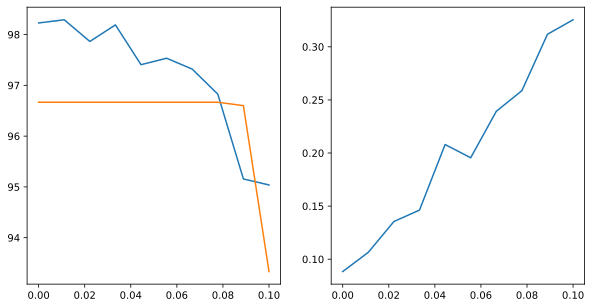

In [421]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].plot(L2_space, results)
#plt.plot(L2_space, testAcc_L2)

ax[1].plot(L2_space, loss_L2)
    

# 76 L2 regularization in practice

In [16]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [17]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa'] = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

In [18]:
# break data into batches
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size= 0.2)

# convert data into pytorch dataset
train_dataDataset = TensorDataset(train_data, train_labels)
test_dataDataset = TensorDataset(test_data, test_labels)

# create dataloader
batch_size = 64
train_loader = DataLoader(train_dataDataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataDataset, batch_size=len(test_data))

Model

In [19]:
# the model
# torch has already build in the L2 regulariztion in it

# define a function to creates the ANN model
def CreateANewModel():

    # model architeture
    ANNIris = nn.Sequential(
        nn.Linear(4, 64), # input layer
        nn.ReLU(), # activation unit
        nn.Linear(64, 64), # hidden layer
        nn.ReLU(), # Activation unit
        nn.Linear(64, 3), # output layer
    )

    lossfunc = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(ANNIris.parameters(), lr=0.005)

    return ANNIris, lossfunc, optimizer
    

In [20]:
tempmodel = CreateANewModel()[0]
print(tempmodel)

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
)


In [21]:
# print model's parameters
for i in tempmodel.named_parameters():
    print(i[0], i[1].shape, i[1].numel())

# name, data shape, total number of elements

0.weight torch.Size([64, 4]) 256
0.bias torch.Size([64]) 64
2.weight torch.Size([64, 64]) 4096
2.bias torch.Size([64]) 64
4.weight torch.Size([3, 64]) 192
4.bias torch.Size([3]) 3


train function

In [24]:
# a global parameter
numepochs = 1000

# helper function
def calc_accuracy(yHat, y):
    matched_label = torch.argmax(yHat, axis = 1)
    fc = (matched_label == y).float()
    return 100 * torch.mean(fc).item()

def trainTheModel(L1Lambda, ANNIris, lossfunc, optimizer, train_loader, test_loader):

    # initialize accuracies as empties
    trainAcc = []
    testAcc = []
    losses = []

    nweights = 0
    for pname, weight in ANNIris.named_parameters():
        if 'bias' not in pname:
            nweights += weight.numel()



    for epochi in range(numepochs):
        # batchAccuracy
        batchAcc = []
        batchLoss = []
        
        for X, y in train_loader:

            # forward pass
            yHat = ANNIris(X)

            # loss
            loss = lossfunc(yHat, y)

            # add L1 term
            L1_term = torch.tensor(0., requires_grad=True)

            # sum up all the abs(weights)
            for pname, weight in ANNIris.named_parameters():
                if 'bias' not in pname:
                    L1_term = L1_term + torch.sum(torch.abs(weight))

            # add to lass term
            loss = loss + L1Lambda * L1_term / nweights
            

            # back propogation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchAcc.append(calc_accuracy(yHat, y))
            batchLoss.append(loss.item())

        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))

        # test accuracy
        # model eval model do two folds: 
        # 1. turn of dropout regularization
        # 2. turn off batch normalization
        # We don't do either dropout or batch normalization here.
        # therefore we don't need it
        # ANNIris.eval() # set the model to eval mode. 
        X, y = next(iter(test_loader))
        yHat = ANNIris(X)
        testAcc.append(calc_accuracy(yHat, y))

        # toggle the model to train mode
        # ANNIris.train()
    # print(loss.item())

    return trainAcc, testAcc, losses
        


In [25]:
# bring it to life
# create and run the model once
L1Lambda = 0.001
ANNIris, lossfunc, optimizer = CreateANewModel()
trainAcc, testAcc, losses = trainTheModel(L1Lambda, ANNIris, lossfunc, optimizer, train_loader, test_loader)


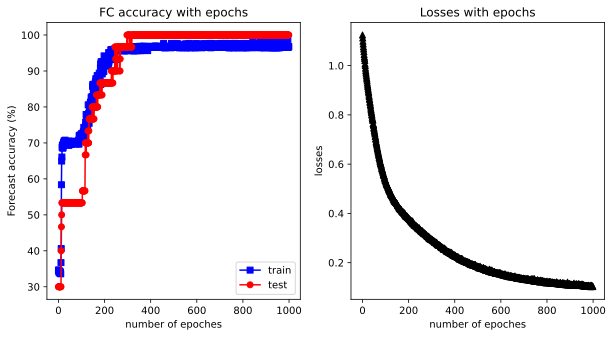

In [26]:

fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].plot(trainAcc, 'bs-')
ax[0].plot(testAcc, 'ro-')
ax[0].set_xlabel('number of epoches')
ax[0].set_ylabel('Forecast accuracy (%)')
ax[0].set_title('FC accuracy with epochs')
ax[0].legend(['train', 'test'])

ax[1].plot(losses, 'k^-')
ax[1].set_xlabel('number of epoches')
ax[1].set_ylabel('losses')
ax[1].set_title('Losses with epochs')

plt.show()

run parametric experiment

In [27]:
# run a parametric experiment
# create a 1D smoothing filter
def smooth(x, k = 5):
    return np.convolve(x, np.ones(k) / k, mode = 'same')

# range of L1 regularization amount
L1Lambdas = np.linspace(0, 0.005, 10)

# initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs, len(L1Lambdas)))
accuracyResultsTest = np.zeros((numepochs, len(L1Lambdas)))

for i, L1Lambda in enumerate(L1Lambdas):

    # create the model and train it
    ANNIris, lossfunc, optimizer = CreateANewModel()
    trainAcc, testAcc, losses = trainTheModel(L1Lambda, ANNIris, lossfunc, optimizer, train_loader, test_loader)

    # store data
    accuracyResultsTrain[:, i] = smooth(trainAcc, 10)
    accuracyResultsTest[:, i] = smooth(testAcc, 10)


[]

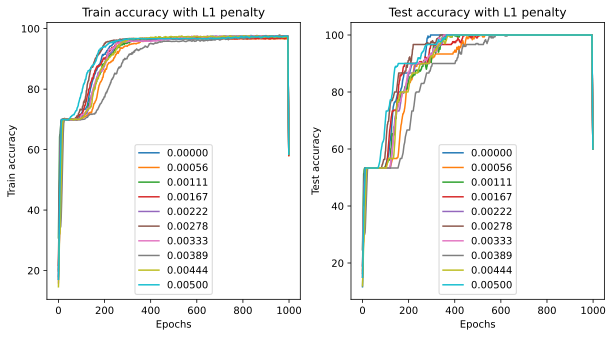

In [34]:
# plot the result
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].plot(accuracyResultsTrain)
ax[0].legend([f'{L1Lambda:.5f}' for L1Lambda in L1Lambdas])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Train accuracy')
ax[0].set_title('Train accuracy with L1 penalty')

ax[1].plot(accuracyResultsTest)
ax[1].legend([f'{L1Lambda:.5f}' for L1Lambda in L1Lambdas])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Test accuracy')
ax[1].set_title('Test accuracy with L1 penalty')

plt.plot()

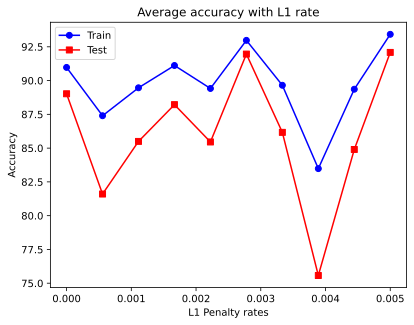

In [38]:
# show the average accuracy by L1 rate

# everage only some epochs to see whether some penalty rates accelerate the training speed
epoch_range = [100, 400]

plt.plot(L1Lambdas, np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1]], axis = 0), 'bo-', label = 'Train')
plt.plot(L1Lambdas, np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1]], axis = 0), 'rs-', label = 'Test')
plt.legend()
plt.xlabel('L1 Penalty rates')
plt.ylabel('Accuracy')
plt.title('Average accuracy with L1 rate')
plt.show()

# 78 Batch training in action

In [39]:
# import library
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [78]:

# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa'] = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

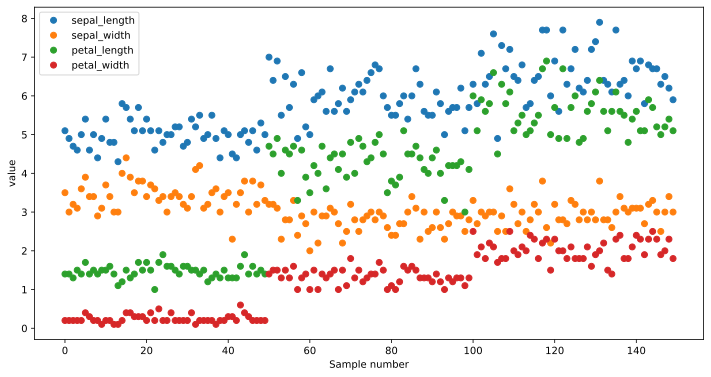

In [79]:
iris.plot(marker = 'o', linestyle = 'none', figsize  = (12, 6))
plt.xlabel('Sample number')
plt.ylabel('value')
plt.show()

In [86]:
# break data into batches
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size= 0.2)

# convert data into pytorch dataset
train_dataDataset = TensorDataset(train_data, train_labels)
test_dataDataset = TensorDataset(test_data, test_labels)

# create dataloader
batch_size = 16
train_loader = DataLoader(train_dataDataset, batch_size=batch_size, shuffle=True, drop_last= True)
test_loader = DataLoader(test_dataDataset, batch_size=len(test_data))

In [87]:
# check sizes of the data batches
for X, y in train_loader:
    print(X.shape, y.shape)

# go back and set drop_last = True in the training DataLoader

torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])


model function

In [88]:
# the model
# torch has already build in the L2 regulariztion in it

# define a function to creates the ANN model
def CreateANewModel():

    # model architeture
    ANNIris = nn.Sequential(
        nn.Linear(4, 64), # input layer
        nn.ReLU(), # activation unit
        nn.Linear(64, 64), # hidden layer
        nn.ReLU(), # Activation unit
        nn.Linear(64, 3), # output layer
    )

    lossfunc = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(ANNIris.parameters(), lr=0.0001)

    return ANNIris, lossfunc, optimizer
    

train function

In [89]:
# a global parameter
numepochs = 1000

# helper function
def calc_accuracy(yHat, y):
    matched_label = torch.argmax(yHat, axis = 1)
    fc = (matched_label == y).float()
    return 100 * torch.mean(fc).item()

def trainTheModel(ANNIris, lossfunc, optimizer, train_loader, test_loader):

    # initialize accuracies as empties
    trainAcc = []
    testAcc = []
    losses = []

    nweights = 0
    for pname, weight in ANNIris.named_parameters():
        if 'bias' not in pname:
            nweights += weight.numel()



    for epochi in range(numepochs):
        # batchAccuracy
        batchAcc = []
        batchLoss = []
        
        for X, y in train_loader:

            # forward pass
            yHat = ANNIris(X)

            # loss
            loss = lossfunc(yHat, y)

            # # add L1 term
            # L1_term = torch.tensor(0., requires_grad=True)

            # # sum up all the abs(weights)
            # for pname, weight in ANNIris.named_parameters():
            #     if 'bias' not in pname:
            #         L1_term = L1_term + torch.sum(torch.abs(weight))

            # # add to lass term
            # loss = loss + L1Lambda * L1_term / nweights
            

            # back propogation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchAcc.append(calc_accuracy(yHat, y))
            batchLoss.append(loss.item())

        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))

        # test accuracy
        # model eval model do two folds: 
        # 1. turn of dropout regularization
        # 2. turn off batch normalization
        # We don't do either dropout or batch normalization here.
        # therefore we don't need it
        # ANNIris.eval() # set the model to eval mode. 
        X, y = next(iter(test_loader))
        yHat = ANNIris(X)
        testAcc.append(calc_accuracy(yHat, y))

        # toggle the model to train mode
        # ANNIris.train()
    # print(loss.item())

    return trainAcc, testAcc, losses

Test it out

In [90]:
# create a model
ANNIris, lossfunc, optimizer = CreateANewModel()
trainAcc, testAcc, losses = trainTheModel(ANNIris, lossfunc, optimizer, train_loader, test_loader)

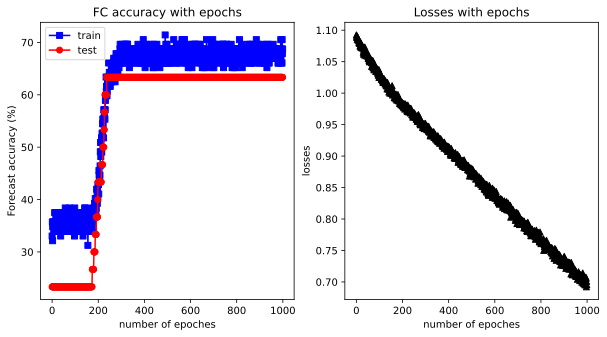

In [91]:

fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].plot(trainAcc, 'bs-')
ax[0].plot(testAcc, 'ro-')
ax[0].set_xlabel('number of epoches')
ax[0].set_ylabel('Forecast accuracy (%)')
ax[0].set_title('FC accuracy with epochs')
ax[0].legend(['train', 'test'])

ax[1].plot(losses, 'k^-')
ax[1].set_xlabel('number of epoches')
ax[1].set_ylabel('losses')
ax[1].set_title('Losses with epochs')

plt.show()